MSIN0097 Individual assignment

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


#Objective

The FAANGs are the five most popular and best-performing technology stocks in the U.S. market. The object of this study is Apple. The goal of this study is to develop a prediction model based on neural networks to predict Apple's future stock price using historical stock data. By comparing the three most popular models, convolutional neural network (CNN), long short-term memory network (LSTM), and gated recurrent unit (GRU) models, we select the one with the best performance and then perform further optimization to obtain more accurate predictions.

Dataset:https://www.kaggle.com/datasets/aayushmishra1512/faang-complete-stock-data

Github:https://github.com/JudyJUJU/MSIN0097.git

#Explore and prepare the data

##Get the data

Looking at the composition of the Apple data set, there are 7 columns of data, including:

Date shows the specific date of the record.

The opening price (Open) is the price of the stock at the beginning of the trading day.

The highest price (High) and the lowest price (Low) respectively represent the highest and lowest trading price of the stock during the trading day.

The closing price (Close) is the price of the stock at the end of the trading day.

Adjusted closing price (Adj Close) is the stock price after taking into account factors such as ex-rights and dividends.

Volume represents the number of shares traded in a trading day.

In [2]:
import pandas as pd
# Load the dataset to check the structure
apple_data = pd.read_csv('/content/drive/MyDrive/97/Apple.csv')

# Display the heads of data to see its structure
apple_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600.0


Missing values and outliers are handled to ensure consistent formatting across all data columns.

In [3]:
# Drop rows with any missing values
apple_data['Company'] = 'Apple'
apple_data_cleaned = apple_data.dropna()

# Check if all missing values are removed and display the new info of the dataframe
apple_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, 0 to 10015
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10015 non-null  object 
 1   Open       10015 non-null  float64
 2   High       10015 non-null  float64
 3   Low        10015 non-null  float64
 4   Close      10015 non-null  float64
 5   Adj Close  10015 non-null  float64
 6   Volume     10015 non-null  float64
 7   Company    10015 non-null  object 
dtypes: float64(6), object(2)
memory usage: 704.2+ KB


##Visualization

Six visual charts representing six different financial metrics for Apple stock over time:


Open: The price of Apple stock at the beginning of each trading day.


High: The highest price reached by Apple stock during a given time period.


Low: The lowest trading price of a stock during the same time period.


Closing price (Close): Apple stock price at the end of the trading day.


Adjusted closing price (Adj Close): The closing price after taking into account factors such as ex-rights and dividends, reflecting the actual value of the stock.


Volume: The total number of Apple shares bought and sold within a certain period of time.

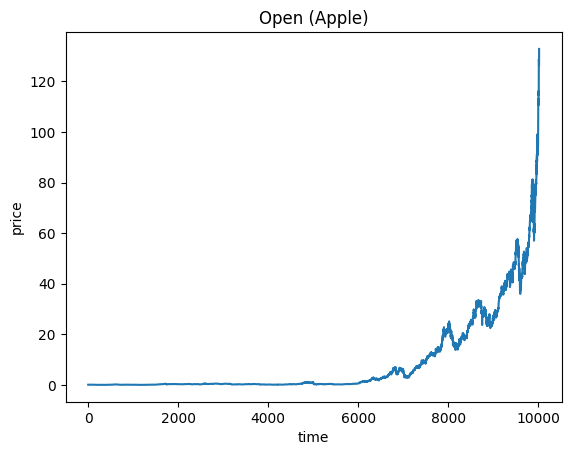

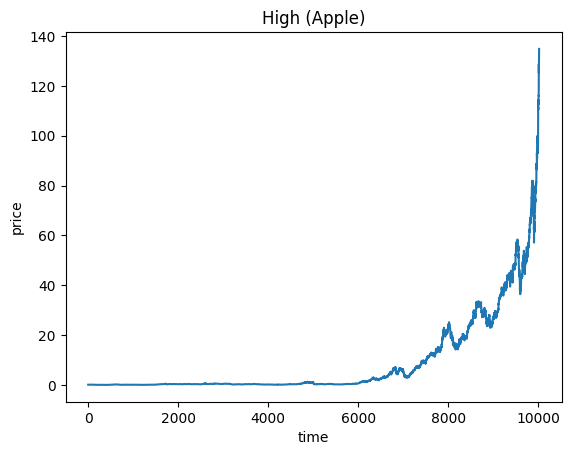

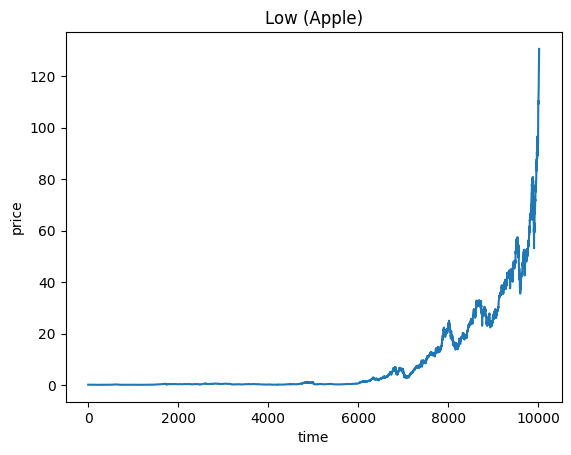

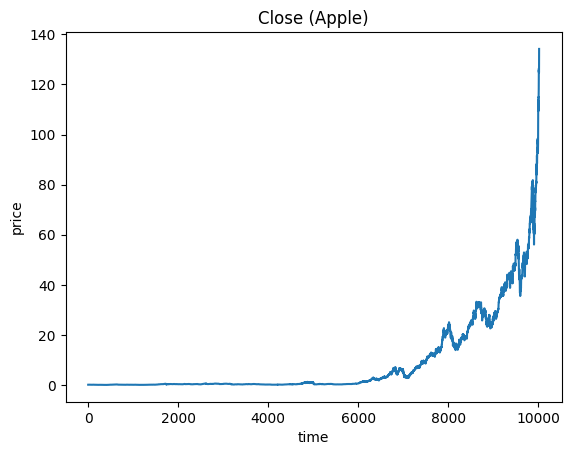

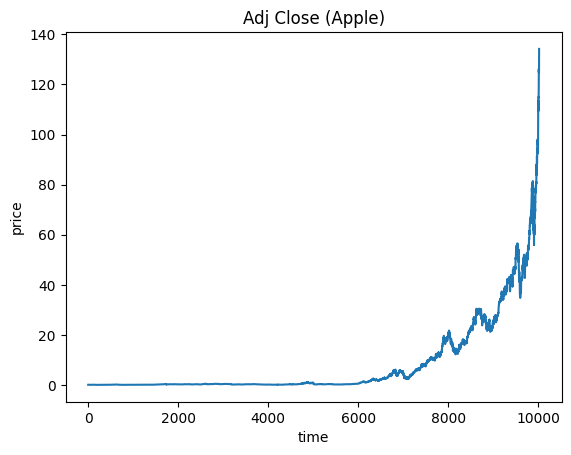

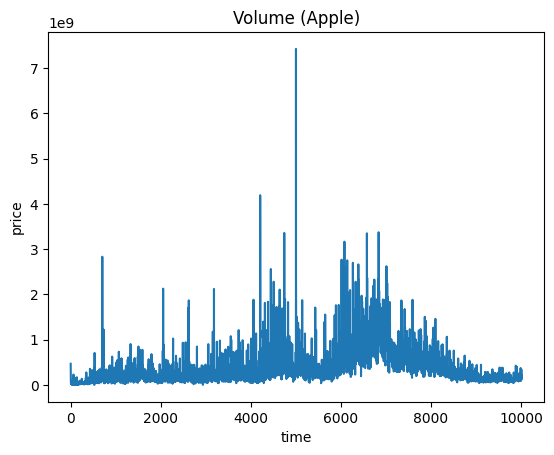

In [4]:
import matplotlib.pyplot as plt

# Plot a time series graph for each financial indicator
for cols in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
  # plt.subplot(1, 6, index)
  xpoints = range(apple_data_cleaned.shape[0])
  # xpoints = apple_data_cleaned["Date"]
  ypoints = apple_data_cleaned[cols]
  plt.plot(xpoints, ypoints)
  plt.xlabel('time')
  plt.ylabel("price")
  plt.title(f"{cols} (Apple)")
  # index += 1
  plt.show()

This picture is a correlation matrix of stock characteristics. There is a very high positive correlation (red square with a value of 1.00) between the open, high, low, close and adjusted close prices because they generally influence each other during the trading day. Volume shows a slight negative correlation with other indicators (blue squares, values around -0.14 to -0.15), which may indicate that volume increases and decreases are not completely in sync with price movements.

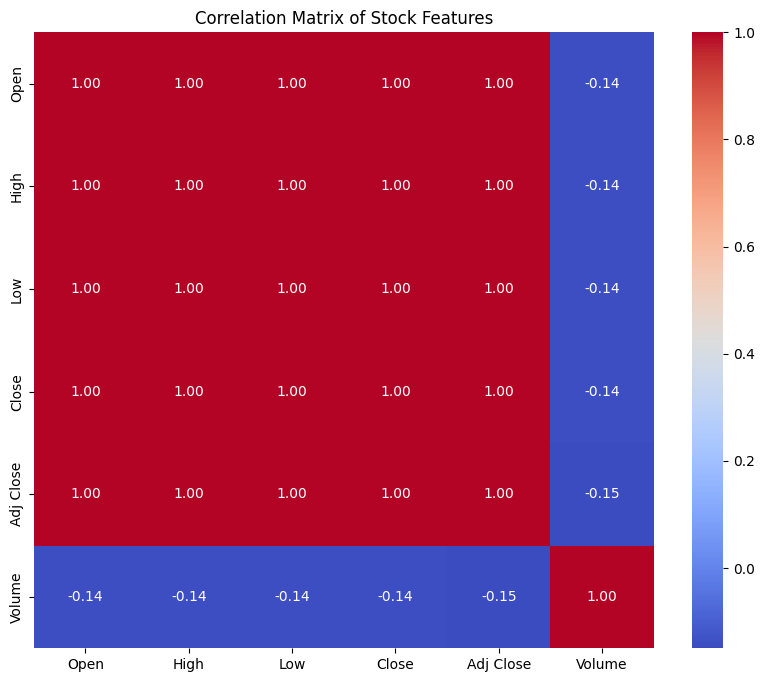

In [5]:
import seaborn as sns
# Calculate correlations between features in the dataset
correlations = apple_data_cleaned[['Open', 'High', 'Low', 'Close', "Adj Close", 'Volume']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Stock Features')
plt.show()

##Feature Scaling

The dataset is split into training and test sets.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(apple_data_cleaned, test_size=0.2, random_state=42)

# Show the number of entries in each set
len(train_set), len(test_set)

(8012, 2003)

Feature engineering was performed on the dataset. A 5-day moving average of volume is calculated, using the average volume over the past five days to provide a smoothed version of daily volume. Daily percentage changes in trading volume are calculated, capturing fluctuations or changes in trading activity. Z-scores were calculated for closing prices, with z-score normalization applied to closing prices using a 200-day rolling window that normalizes these prices by mean and standard deviation, helping to identify price anomalies. A volume percentile rank is calculated, using the relative ranking of each day's volume over a 200-day period, to provide a percentage-based position of a given volume relative to historical volume. Volume is classified into deciles, providing a categorical representation of volume as one of ten possible values, which can help models identify patterns based on volume size categories.

In [7]:
# Sort the datasets by date for chronological order and reset index
train_set = train_set.sort_values(by=["Date"]).reset_index(drop=True)
test_set = test_set.sort_values(by=["Date"]).reset_index(drop=True)

# Compute and add the 5-day moving average of the Volume in the datasets
ma_5 = lambda x: x.rolling(5).mean()
train_set["ma_5"] = train_set.groupby('Company')["Volume"].apply(ma_5).values
test_set["ma_5"] = test_set.groupby('Company')["Volume"].apply(ma_5).values

# Calculate and add the percentage change of the Volume in the datasets
pct_chg_fxn = lambda x: x.pct_change()
train_set["pct"] = train_set.groupby('Company')["Volume"].apply(pct_chg_fxn).values
test_set["pct"] = test_set.groupby('Company')["Volume"].apply(pct_chg_fxn).values

# Calculate and add a z-score of the Close prices, using a rolling window of 200 with a minimum period of 20
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/ x.rolling(window=200, min_periods=20).std()
train_set['zscore'] = train_set.groupby('Company')["Close"].apply(zscore_fun_improved).values
test_set['zscore'] = test_set.groupby('Company')["Close"].apply(zscore_fun_improved).values

# Calculate and add the percentile rank of Volume within a 200-day rolling window with at least 20 values
rollrank_fxn = lambda x: x.rolling(200,min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0])
train_set["percentile"] = train_set.groupby('Company')["Volume"].apply(pct_chg_fxn).values
test_set["percentile"] = test_set.groupby('Company')["Volume"].apply(pct_chg_fxn).values

# Bin the Volume into deciles and add it as a new feature
bin_fxn = lambda y: pd.qcut(y,q=10,labels = range(1,10+1))
train_set["bin"] = train_set.groupby('Company')["Volume"].apply(bin_fxn).values
test_set["bin"] = test_set.groupby('Company')["Volume"].apply(bin_fxn).values

The adjusted closing price is set as the target variable for prediction and then removed from the dataset to ensure that it is not used as a feature.

In [8]:
# Set the adjusted closing price as the prediction target variable and remove it from the features
train_set["target"] = train_set["Adj Close"]
test_set["target"] = test_set["Adj Close"]

train_set = train_set.drop(columns=["Adj Close"])
test_set = test_set.drop(columns=["Adj Close"])

# Remove any rows containing missing values
train_set.dropna(inplace=True)
test_set.dropna(inplace=True)

test_set.head()

,Date,Open,High,Low,Close,Volume,Company,ma_5,pct,zscore,percentile,bin,target
19,1981-03-09,0.106027,0.106027,0.105469,0.105469,15321600.0,Apple,16773120.0,-0.213793,-1.766085,-0.213793,1,0.083210
20,1981-03-10,0.101004,0.101004,0.100446,0.100446,28380800.0,Apple,20863360.0,0.852339,-1.857759,0.852339,1,0.079248
21,1981-04-02,0.117746,0.118304,0.117746,0.117746,31404800.0,Apple,23793280.0,0.106551,-0.758183,0.106551,1,0.092896
22,1981-04-08,0.120536,0.121652,0.120536,0.120536,21952000.0,Apple,23309440.0,-0.300999,-0.567087,-0.300999,1,0.095097
23,1981-04-21,0.122768,0.123326,0.122768,0.122768,28537600.0,Apple,25119360.0,0.300000,-0.415127,0.300000,1,0.096858


Start by defining a ColumnTransformer to normalize numeric features such as open, high, low, close, and volume, and include derived features such as percent change, moving average, z-score, percentile, and volume decile. These transformations are encapsulated in pipelines to normalize the data. Next, the function create_sequences reorganizes the data set into a sequence of specified number of time steps (n_steps). Each sequence consists of data from 60 previous time steps. After converting and reshaping the data into sequences, the converted training set is used to create the training data sequence (X_train, y_train) and similarly, the test set is processed to create the test data sequence (X_test, y_test).

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pickle

# Define a column transformer to standardize numerical features
column_transformer = ColumnTransformer([
    # ('cat', OneHotEncoder(), ['Company']),
    ('num', StandardScaler(), ['Open', 'High', 'Low', 'Close', 'Volume', 'pct', "ma_5", "zscore", "percentile", "bin"])
])

# Create a pipeline to apply the transformation
transformation_pipeline = Pipeline([
    ('transform', column_transformer)
])

# Apply the transformation pipeline to the training dataset
train_set_transformed = transformation_pipeline.fit_transform(train_set)

In [10]:
train_set.dropna(inplace=True)
test_set.dropna(inplace=True)


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pickle

# This function transforms a given dataset into sequences for time-series forecasting
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

# Define a ColumnTransformer with one-hot encoding for categorical and standard scaling for numerical features
column_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(), ['Company']),
    ('num', StandardScaler(), ['Open', 'High', 'Low', 'Close', 'Volume', 'pct', "ma_5", "zscore", "percentile", "bin", "target"])
])

# Create a Pipeline to apply the transformations
transformation_pipeline = Pipeline([
    ('transform', column_transformer)
])

# Apply the transformation to the training data
train_set_transformed = transformation_pipeline.fit_transform(train_set)
# Apply the same transformation to the test data
test_set_transformed = transformation_pipeline.transform(test_set)

n_steps = 60  # Number of time steps to use for sequences
# Create training sequences using the transformed training set
X_train, y_train = create_sequences(train_set_transformed, n_steps)
# Create testing sequences using the transformed test set
X_test, y_test = create_sequences(test_set_transformed, n_steps)

X_test.shape, y_test.shape

((1924, 60, 12), (1924,))

In [11]:
# Save the processed data as a JSON file for use during model training
import json
data = {"train_x": X_train.tolist(), "train_y": y_train.tolist(), "test_x": X_test.tolist(), "test_y":y_test.tolist()}
with open("/content/drive/MyDrive/97/best_model/data.json", "w", encoding="utf-8") as f:
  json.dump(data, f)

In [12]:
# Load data from a JSON file and convert it to a Numpy array for use by the model
import json
with open("/content/drive/MyDrive/97/best_model/data.json", "r", encoding="utf-8") as f:
  data = json.load(f)
X_train, y_train, X_test, y_test = data["train_x"], data["train_y"], data["test_x"], data["test_y"]
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7933, 60, 12) (7933,) (1924, 60, 12) (1924,)


#Model Exploration

##CNN

CNN is good at processing large-scale data sets, automatically identifying and learning useful features from input data, which is especially useful for the identification of complex and hidden patterns in the stock market. CNN can effectively handle multi-dimensional time series.

To ensure reproducibility in deep learning experiments, the same results can be obtained when running the code at different times by controlling the seed of the random number generator.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import os, random
import tensorflow as tf
import pickle

seed = 1234
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

The Simple CNN model is designed using a convolutional neural network architecture customized for time series data. It employs two 1D convolutional layers interspersed with dropout layers for regularization, and a flattening layer followed by a dense layer to output predictions. The model is optimized using the Adam optimizer, which can handle large datasets and models efficiently. The model was optimized using SGD with a learning rate of 0.001, momentum of 0.9, and Nesterov acceleration enabled. Training involves a sequence of 20 epochs, with checkpoints set to save the model with the lowest validation loss.

In [14]:
# @title simple_CNN
# Configure the SGD optimizer with specific learning rate, momentum, and Nesterov acceleration
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set up a model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/cnn_model.h5', monitor='val_loss', mode='auto', save_best_only='True', save_weights_only=False)
callback_lists = [checkpoint]

# Build a simple CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
# Compile the model with Adam optimizer and mean squared error loss
cnn_model.compile(optimizer="adam", loss='mse')
# Output model summary
cnn_model.summary()

# Train the model with the training set, validate with the test set, and apply callbacks
cnn_model_history = cnn_model.fit(X_train, y_train, epochs=20, verbose=1, batch_size=32, validation_data=(X_test, y_test), callbacks=callback_lists)
# Save the training history to a file
with open('/content/drive/MyDrive/97/best_model/cnn_model_history.txt', 'wb') as file_pi:
    pickle.dump(cnn_model_history.history, file_pi)
# Predict using the test set
cnn_predictions = cnn_model.predict(X_test)

# Calculate and print error metrics
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_rmse = np.sqrt(cnn_mse)
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)

print("CNN MSE:", cnn_mse)
print("CNN RMSE:", cnn_rmse)
print("CNN MAE:", cnn_mae)
print("CNN R² score:", cnn_r2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 32)            800       
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 29, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 64)            4160      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 64)            0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 3s 13ms/step - loss: 0.0224 - val_loss: 0.1274
Epoch 3/20
248/248 [==============================] - 5s 20ms/step - loss: 0.0147 - val_loss: 0.1492
Epoch 4/20
248/248 [==============================] - 4s 15ms/step - loss: 0.0139 - val_loss: 0.1147
Epoch 5/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0110 - val_loss: 0.1289
Epoch 6/20
248/248 [==============================] - 2s 7ms/step - loss: 0.0096 - val_loss: 0.1382
Epoch 7/20
248/248 [==============================] - 2s 7ms/step - loss: 0.0094 - val_loss: 0.1279
Epoch 8/20
248/248 [==============================] - 2s 9ms/step - loss: 0.0092 - val_loss: 0.1176
Epoch 9/20
248/248 [==============================] - 3s 12ms/step - loss: 0.0097 - val_loss: 0.0995
Epoch 10/20
248/248 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.1217
Epoch 11/20
248/248 [==============================] - 2s 7ms/step - loss: 0.0097 - val_loss: 0.1181
Epoch

In [15]:
from keras.models import load_model

# Load the best saved CNN model from file
best_cnn_model = load_model("/content/drive/MyDrive/97/best_model/cnn_model.h5")

# Make predictions using the test dataset
cnn_predictions = best_cnn_model.predict(X_test)

# Calculate and display various error metrics
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_rmse = np.sqrt(cnn_mse)
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)

print("CNN MSE:", cnn_mse)
print("CNN RMSE:", cnn_rmse)
print("CNN MAE:", cnn_mae)
print("CNN R² score:", cnn_r2)

61/61 [==============================] - 0s 3ms/step
CNN MSE: 0.083231407661092
CNN RMSE: 0.2884985401368471
CNN MAE: 0.16415702196204618
CNN R² score: 0.9276249222065112


Performance Metrics:

MSE: 0.1386 (Training) / 0.0832 (Test)

RMSE: 0.3723 (Training) / 0.2885 (Test)

MAE: 0.2085 (Training) / 0.1642 (Test)

R² Score: 0.8794 (Training) / 0.9276 (Test)

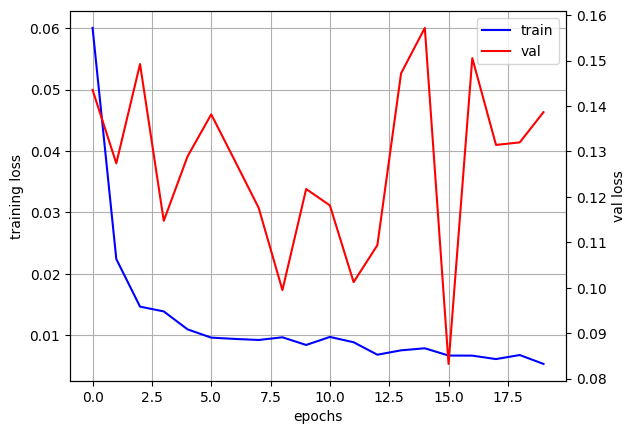

In [16]:
import pickle
# Load the saved training history from a file
with open("/content/drive/MyDrive/97/best_model/cnn_model_history.txt", 'rb') as file_pi:
    history = pickle.load(file_pi)

import matplotlib.pyplot as plt

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, history['val_loss'], 'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel("training loss")
ax2.set_ylabel("val loss")
# Combine legends from both plots and display
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/simple_cnn_loss.jpg')
plt.show()

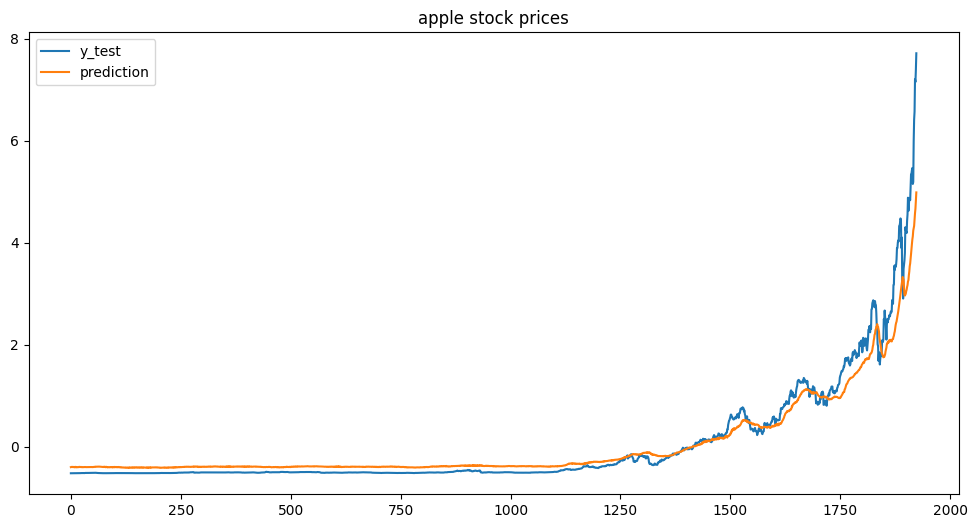

In [17]:
import matplotlib.pyplot as plt

# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(cnn_predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.show()

The enhanced CNN model is designed with more convolutional layers with greater depth, additional dropout layers to avoid overfitting, and dense layers for nonlinear transformations before outputting. The model is also optimized using the Adam optimizer. Training also spans 20 epochs and the model is saved in real time based on validation loss performance.

In [18]:
# @title enhanced_CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Setup model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/enhanced_cnn_model.h5', monitor='val_loss', mode='auto', save_best_only='True', save_weights_only=False)
callback_lists = [checkpoint]

# Build a more complex CNN model
enhanced_cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
enhanced_cnn_model.compile(optimizer='adam', loss='mse')
enhanced_cnn_model.summary()

# Train the model and save the training history
enhanced_cnn_model_history = enhanced_cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1, batch_size=32, callbacks=callback_lists)
with open('/content/drive/MyDrive/97/best_model/enhanced_cnn_model_history.txt', 'wb') as file:
    pickle.dump(enhanced_cnn_model_history.history, file)

# Predict using the enhanced model
enhanced_cnn_predictions = enhanced_cnn_model.predict(X_test)

# Calculate and print error metrics for the enhanced model
enhanced_cnn_mse = mean_squared_error(y_test, enhanced_cnn_predictions)
enhanced_cnn_rmse = np.sqrt(enhanced_cnn_mse)
enhanced_cnn_mae = mean_absolute_error(y_test, enhanced_cnn_predictions)
enhanced_cnn_r2 = r2_score(y_test, enhanced_cnn_predictions)

print("Enhanced CNN MSE:", enhanced_cnn_mse)
print("Enhanced CNN RMSE:", enhanced_cnn_rmse)
print("Enhanced CNN MAE:", enhanced_cnn_mae)
print("Enhanced CNN R² score:", enhanced_cnn_r2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 58, 128)           4736      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 29, 128)           0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 29, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 27, 64)            24640     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 832)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 3s 12ms/step - loss: 0.0374 - val_loss: 0.0386
Epoch 3/20
248/248 [==============================] - 3s 12ms/step - loss: 0.0317 - val_loss: 0.0890
Epoch 4/20
248/248 [==============================] - 4s 17ms/step - loss: 0.0232 - val_loss: 0.0832
Epoch 5/20
248/248 [==============================] - 4s 14ms/step - loss: 0.0226 - val_loss: 0.0630
Epoch 6/20
248/248 [==============================] - 3s 12ms/step - loss: 0.0242 - val_loss: 0.0605
Epoch 7/20
248/248 [==============================] - 3s 12ms/step - loss: 0.0247 - val_loss: 0.1103
Epoch 8/20
248/248 [==============================] - 4s 16ms/step - loss: 0.0213 - val_loss: 0.0572
Epoch 9/20
248/248 [==============================] - 4s 14ms/step - loss: 0.0228 - val_loss: 0.0962
Epoch 10/20
248/248 [==============================] - 3s 12ms/step - loss: 0.0199 - val_loss: 0.0748
Epoch 11/20
248/248 [==============================] - 3s 12ms/step - loss: 0.0208 - val_loss: 0.0494

In [19]:
# Load the best saved enhanced CNN model
best_enhanced_cnn_model = load_model("/content/drive/MyDrive/97/best_model/enhanced_cnn_model.h5")

# Make predictions using the test dataset with the loaded model
best_enhanced_cnn_model_predictions = best_enhanced_cnn_model.predict(X_test)

# Calculate various error metrics to evaluate the model's performance
best_enhanced_cnn_model_mse = mean_squared_error(y_test, best_enhanced_cnn_model_predictions)
best_enhanced_cnn_model_rmse = np.sqrt(best_enhanced_cnn_model_mse)
best_enhanced_cnn_model_mae = mean_absolute_error(y_test, best_enhanced_cnn_model_predictions)
best_enhanced_cnn_model_r2 = r2_score(y_test, best_enhanced_cnn_model_predictions)

print("best_enhanced_cnn_model MSE:", best_enhanced_cnn_model_mse)
print("best_enhanced_cnn_model RMSE:", best_enhanced_cnn_model_rmse)
print("best_enhanced_cnn_model MAE:", best_enhanced_cnn_model_mae)
print("best_enhanced_cnn_model R² score:", best_enhanced_cnn_model_r2)

61/61 [==============================] - 0s 4ms/step
best_enhanced_cnn_model MSE: 0.02917720184862208
best_enhanced_cnn_model RMSE: 0.1708133538357645
best_enhanced_cnn_model MAE: 0.0730566417971718
best_enhanced_cnn_model R² score: 0.9746285409206469


Performance Metrics:

MSE: 0.03497 (Training) / 0.02918 (Test)

RMSE: 0.1870 (Training) / 0.1708 (Test)

MAE: 0.0692 (Training) / 0.0731 (Test)

R² Score: 0.9696 (Training) / 0.9746 (Test)

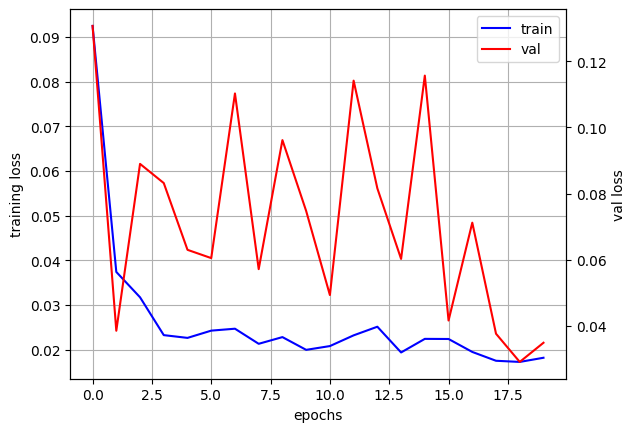

In [21]:
import matplotlib.pyplot as plt
import pickle

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, enhanced_cnn_model_history.history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, enhanced_cnn_model_history.history['val_loss'],'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel(r"training loss")
ax2.set_ylabel(r"val loss")
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/enhanced_cnn_model.jpg')
plt.show()

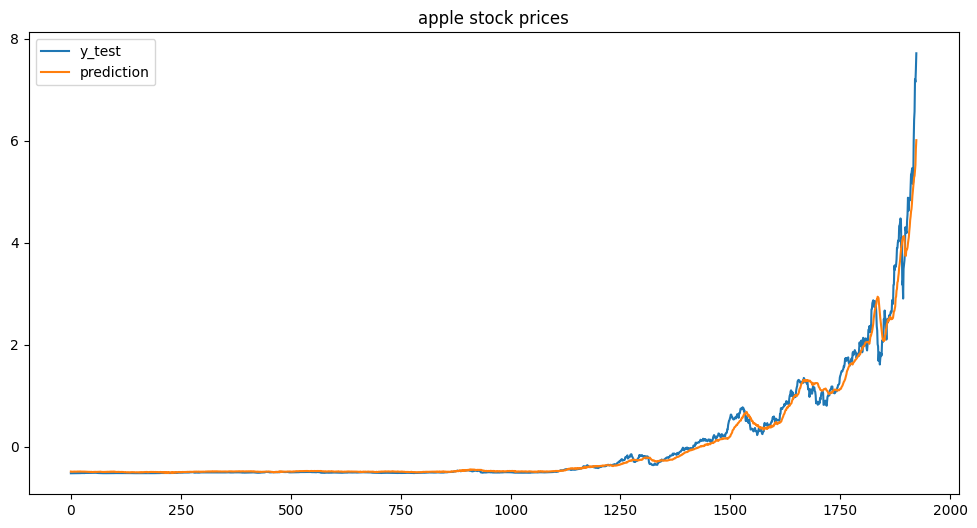

In [22]:
import matplotlib.pyplot as plt
# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(best_enhanced_cnn_model_predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.show()

The enhanced CNN model outperforms the simple CNN model in all metrics. However, comparing with the two following models, it is not suitable for predicting stock price.

##GRU

GRU models are a type of RNN particularly adept at handling sequences of data, such as time series information, which makes them highly applicable for predicting stock prices. GRU simplifies the architecture of traditional RNNs by combining the forget and input gates into a single "update gate."  GRUs are generally faster to train than more complex models like LSTM due to their simpler structure.

The Simple GRU model is straightforward, consisting of two GRU layers and a dense output layer. The model is optimized using the Adam optimizer. Training runs for 20 epochs with a batch size of 32, balancing speed and learning stability.

In [23]:
# @title simple_GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time

# Set up a checkpoint to save the best model during training based on validation loss
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/simple_gru_model.h5', monitor='val_loss', mode='auto', save_best_only='True', save_weights_only=False)
callback_lists = [checkpoint]

# Build a simple GRU-based model
simple_gru_model = Sequential([
    GRU(50, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(80, activation='relu'),
    Dense(1)
])
simple_gru_model.compile(optimizer='adam', loss='mse')
simple_gru_model.summary()

# Train the model and measure the training time
t1 = time.time()
simple_gru_model_history = simple_gru_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1, callbacks=callback_lists)
t2 = time.time() - t1
print("Training duration: {} hours".format(t2/3600))

# Save the training history to a file
with open('/content/drive/MyDrive/97/best_model/simple_gru_model_history.txt', 'wb') as file:
    pickle.dump(simple_gru_model_history.history, file)

# Make predictions with the trained model
simple_gru_predictions = simple_gru_model.predict(X_test)

# Calculate and print the error metrics
simple_gru_mse = mean_squared_error(y_test, simple_gru_predictions)
simple_gru_rmse = np.sqrt(simple_gru_mse)
simple_gru_mae = mean_absolute_error(y_test, simple_gru_predictions)
simple_gru_r2 = r2_score(y_test, simple_gru_predictions)

print("Simple GRU MSE:", simple_gru_mse)
print("Simple GRU RMSE:", simple_gru_rmse)
print("Simple GRU MAE:", simple_gru_mae)
print("Simple GRU R² score:", simple_gru_r2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            9600      
                                                                 
 gru_1 (GRU)                 (None, 80)                31680     
                                                                 
 dense_4 (Dense)             (None, 1)                 81        
                                                                 
Total params: 41361 (161.57 KB)
Trainable params: 41361 (161.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
248/248 [==============================] - 24s 70ms/step - loss: 0.0577 - val_loss: 0.0107
Epoch 2/20
  2/248 [..............................] - ETA: 12s - loss: 0.0012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 15s 62ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 3/20
248/248 [==============================] - 15s 62ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 4/20
248/248 [==============================] - 15s 60ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 5/20
248/248 [==============================] - 16s 63ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 6/20
248/248 [==============================] - 18s 72ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 7/20
248/248 [==============================] - 15s 60ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 8/20
248/248 [==============================] - 15s 62ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 9/20
248/248 [==============================] - 15s 61ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 10/20
248/248 [==============================] - 15s 60ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 11/20
248/248 [==============================] - 15s 60ms/step - loss: 0.0010 - val_lo

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the best saved model from the specified file
best_simple_gru_model = load_model("/content/drive/MyDrive/97/best_model/simple_gru_model.h5")

# Make predictions using the test data with the loaded model
best_simple_gru_model_predictions = best_simple_gru_model.predict(X_test)

# Calculate error metrics to evaluate the model's performance
best_simple_gru_model_predictions_mse = mean_squared_error(y_test, best_simple_gru_model_predictions)
best_simple_gru_model_predictions_rmse = np.sqrt(best_simple_gru_model_predictions_mse)
best_simple_gru_model_predictions_mae = mean_absolute_error(y_test, best_simple_gru_model_predictions)
best_simple_gru_model_predictions_r2 = r2_score(y_test, best_simple_gru_model_predictions)

print("best_simple_gru_model MSE:", best_simple_gru_model_predictions_mse)
print("best_simple_gru_model RMSE:", best_simple_gru_model_predictions_rmse)
print("best_simple_gru_model MAE:", best_simple_gru_model_predictions_mae)
print("best_simple_gru_model R² score:", best_simple_gru_model_predictions_r2)

61/61 [==============================] - 1s 14ms/step
best_simple_gru_model MSE: 0.0034394099287959
best_simple_gru_model RMSE: 0.05864648266346329
best_simple_gru_model MAE: 0.020869028166739276
best_simple_gru_model R² score: 0.9970092112081788


Performance Metrics:

MSE: 0.0035 (Training) / 0.0034 (Test)

RMSE: 0.0588 (Training) / 0.0586 (Test)

MAE: 0.0208 (Training) / 0.0209 (Test)

R² Score: 0.9970 (Training) / 0.9970 (Test)

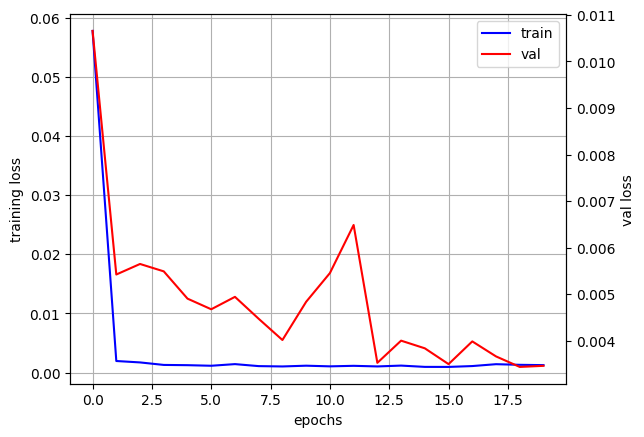

In [26]:
import matplotlib.pyplot as plt
import pickle

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, simple_gru_model_history.history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, simple_gru_model_history.history['val_loss'],'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel(r"training loss")
ax2.set_ylabel(r"val loss")
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/best_simple_gru_model.jpg')
plt.show()

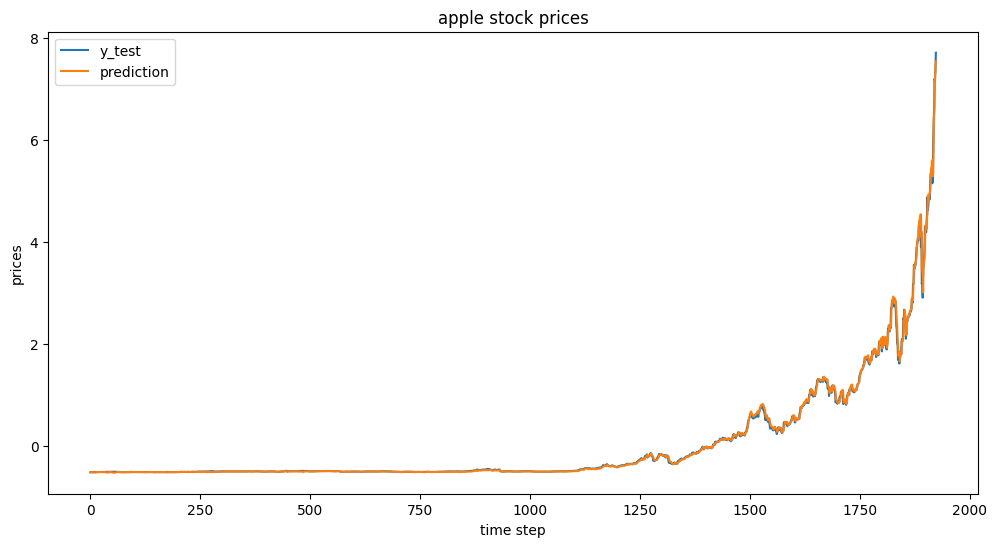

In [27]:
import matplotlib.pyplot as plt

# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(best_simple_gru_model_predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.xlabel('time step')
plt.ylabel('prices')
plt.show()

In contrast, enhanced GRU model incorporates additional GRU layers and increased dropout for regularization. The model is also optimized using the Adam optimizer. The model also trains over 20 epochs with a batch size of 32.

In [28]:
# @title enhanced_GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time

# Setup a checkpoint to automatically save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/enhanced_gru_model.h5', monitor='val_loss', mode='auto', save_best_only='True', save_weights_only=False)
callback_lists = [checkpoint]

# Build an enhanced GRU model with additional layers and dropout for regularization
enhanced_gru_model = Sequential([
    GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1)
])
enhanced_gru_model.compile(optimizer='adam', loss='mse')
enhanced_gru_model.summary()

# Train the model and measure the training duration
t1 = time.time()
enhanced_gru_model_history = enhanced_gru_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1, callbacks=callback_lists)
t2 = time.time() - t1
print("Training duration: {:.2f} hours".format(t2/3600))

# Save the training history to a file for later analysis
with open('/content/drive/MyDrive/97/best_model/enhanced_gru_model_history.txt', 'wb') as file:
    pickle.dump(enhanced_gru_model_history.history, file)

# Make predictions with the trained model
enhanced_gru_predictions = enhanced_gru_model.predict(X_test)

# Calculate and print the error metrics to evaluate the model's performance
enhanced_gru_mse = mean_squared_error(y_test, enhanced_gru_predictions)
enhanced_gru_rmse = np.sqrt(enhanced_gru_mse)
enhanced_gru_mae = mean_absolute_error(y_test, enhanced_gru_predictions)
enhanced_gru_r2 = r2_score(y_test, enhanced_gru_predictions)

print("Enhanced GRU MSE:", enhanced_gru_mse)
print("Enhanced GRU RMSE:", enhanced_gru_rmse)
print("Enhanced GRU MAE:", enhanced_gru_mae)
print("Enhanced GRU R² score:", enhanced_gru_r2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 60, 100)           34200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 100)           0         
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 105001 (410.16 KB)
Trainable params: 105

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 22s 87ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 3/20
248/248 [==============================] - 22s 90ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 4/20
248/248 [==============================] - 23s 91ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 5/20
248/248 [==============================] - 21s 87ms/step - loss: 0.0082 - val_loss: 0.0053
Epoch 6/20
248/248 [==============================] - 23s 92ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 7/20
248/248 [==============================] - 22s 87ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 8/20
248/248 [==============================] - 22s 89ms/step - loss: 0.0060 - val_loss: 0.0102
Epoch 9/20
248/248 [==============================] - 22s 90ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 10/20
248/248 [==============================] - 21s 85ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 11/20
248/248 [==============================] - 24s 97ms/step - loss: 0.0050 - val_lo

In [29]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the previously saved enhanced GRU model from file
best_enhanced_gru_model = load_model("/content/drive/MyDrive/97/best_model/enhanced_gru_model.h5")

# Use the loaded model to make predictions on the test dataset
best_enhanced_gru_model_predictions = best_enhanced_gru_model.predict(X_test)

# Calculate error metrics to assess the model's performance
best_enhanced_gru_model_predictions_mse = mean_squared_error(y_test, best_enhanced_gru_model_predictions)
best_enhanced_gru_model_predictions_rmse = np.sqrt(best_enhanced_gru_model_predictions_mse)
best_enhanced_gru_model_predictions_mae = mean_absolute_error(y_test, best_enhanced_gru_model_predictions)
best_enhanced_gru_model_predictions_r2 = r2_score(y_test, best_enhanced_gru_model_predictions)

print("best_enhanced_gru_model MSE:", best_enhanced_gru_model_predictions_mse)
print("best_enhanced_gru_model RMSE:", best_enhanced_gru_model_predictions_rmse)
print("best_enhanced_gru_model MAE:", best_enhanced_gru_model_predictions_mae)
print("best_enhanced_gru_model R² score:", best_enhanced_gru_model_predictions_r2)

61/61 [==============================] - 3s 22ms/step
best_enhanced_gru_model MSE: 0.004536455296631626
best_enhanced_gru_model RMSE: 0.06735321296442826
best_enhanced_gru_model MAE: 0.027940066693931988
best_enhanced_gru_model R² score: 0.996055259496063


Performance Metrics:

MSE: 0.0046 (Training) / 0.0045 (Test)

RMSE: 0.0675 (Training) / 0.0674 (Test)

MAE: 0.0277 (Training) / 0.0279 (Test)

R² Score: 0.9960 (Training) / 0.9961 (Test)

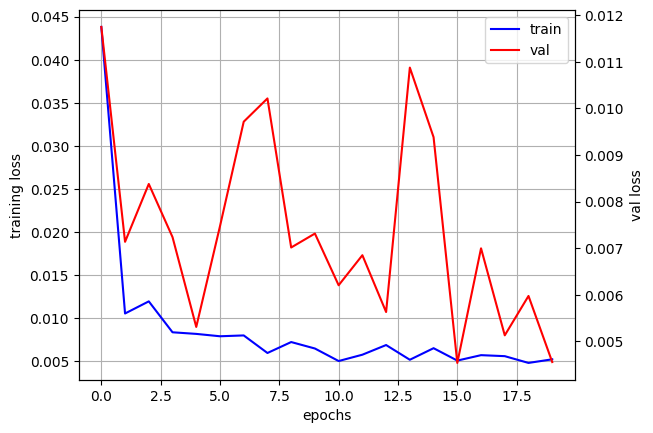

In [30]:
import pickle

# Load the best saved GRU model from file
with open("/content/drive/MyDrive/97/best_model/enhanced_gru_model_history.txt",'rb') as file_pi:
    history=pickle.load(file_pi)

import matplotlib.pyplot as plt

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, history['val_loss'],'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel(r"training loss")
ax2.set_ylabel(r"val loss")
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/best_enhanced_gru_model.jpg')
plt.show()

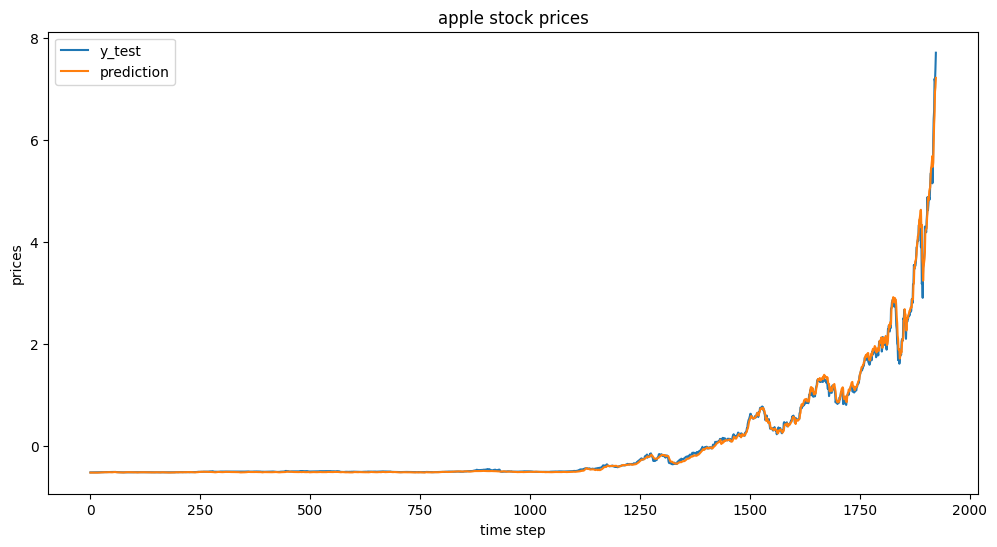

In [31]:
import matplotlib.pyplot as plt

# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(best_enhanced_gru_model_predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.xlabel('time step')
plt.ylabel('prices')
plt.show()

Both models exhibit high accuracy, as indicated by the R² scores close to 1.0. The results demonstrates their efficacy in predicting stock prices. The Simple GRU model, despite its lower complexity, slightly outperforms the enhanced GRU model.

##LSTM

LSTM aims to learn complex patterns from time series data by remembering long-term dependencies by maintaining states over time, and is suitable for continuous data such as stock prices. Unlike traditional time series models, LSTMs can learn which past data needs to be kept and which needs to be discarded. LSTM alleviates the vanishing gradient problem that can occur with standard RNNs during backpropagation, and they can also integrate multiple features into the learning process.

The simple LSTM model consists of a single LSTM layer followed by a dense layer. The LSTM layer has 50 units. The model is trained using the Adam optimizer and training involves 20 epochs.

In [32]:
# @title simple_LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Configure model checkpointing to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/lstm_model.h5', monitor='val_loss',mode='auto' ,save_best_only='True', save_weights_only=False)
callback_lists=[checkpoint]

# Build a simple LSTM model with one LSTM layer and one output layer
lstm_model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Train the model and measure training duration
t1 = time.time()
lstm_model_history = lstm_model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=callback_lists)
t2 = time.time() - t1
print("Training duration: {:.2f} hours".format(t2/3600))

# Save the training history for later analysis
with open('/content/drive/MyDrive/97/best_model/lstm_model_history.txt', 'wb') as file:
    pickle.dump(lstm_model_history.history, file)

# Make predictions using the trained model
lstm_predictions = lstm_model.predict(X_test)

# Calculate and print error metrics to evaluate the model's performance
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print("LSTM MSE:", lstm_mse)
print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("LSTM R² score:", lstm_r2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12600     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12651 (49.42 KB)
Trainable params: 12651 (49.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
248/248 [==============================] - 9s 27ms/step - loss: 0.0550 - val_loss: 0.0140
Epoch 2/20
  7/248 [..............................] - ETA: 5s - loss: 0.0012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 7s 28ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 3/20
248/248 [==============================] - 6s 25ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 4/20
248/248 [==============================] - 7s 29ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 5/20
248/248 [==============================] - 6s 24ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 6/20
248/248 [==============================] - 6s 26ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 7/20
248/248 [==============================] - 7s 26ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 8/20
248/248 [==============================] - 6s 24ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 9/20
248/248 [==============================] - 7s 29ms/step - loss: 0.0010 - val_loss: 0.0057
Epoch 10/20
248/248 [==============================] - 6s 24ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 11/20
248/248 [==============================] - 7s 29ms/step - loss: 0.0011 - val_loss: 0.0070

In [33]:
# Load the best saved LSTM model from file
best_lstm_model = load_model("/content/drive/MyDrive/97/best_model/lstm_model.h5")

# Make predictions using the loaded model on the test dataset
best_lstm_model_predictions = best_lstm_model.predict(X_test)

# Calculate error metrics to evaluate the model's performance
best_lstm_model_predictions_mse = mean_squared_error(y_test, best_lstm_model_predictions)
best_lstm_model_predictions_rmse = np.sqrt(best_lstm_model_predictions_mse)
best_lstm_model_predictions_mae = mean_absolute_error(y_test, best_lstm_model_predictions)
best_lstm_model_predictions_r2 = r2_score(y_test, best_lstm_model_predictions)

print("best_lstm_model MSE:", best_lstm_model_predictions_mse)
print("best_lstm_model RMSE:", best_lstm_model_predictions_rmse)
print("best_lstm_model MAE:", best_lstm_model_predictions_mae)
print("best_lstm_model R² score:", best_lstm_model_predictions_r2)

61/61 [==============================] - 1s 8ms/step
best_lstm_model MSE: 0.003841712450110474
best_lstm_model RMSE: 0.06198154927162174
best_lstm_model MAE: 0.02141216329242389
best_lstm_model R² score: 0.9966593832154188


Performance Metrics:

MSE: 0.0038 (Training) / 0.0038 (Test)

RMSE: 0.0620 (Training) / 0.0620 (Test)

MAE: 0.0214 (Training) / 0.0214 (Test)

R² Score: 0.9967 (Training) / 0.9967 (Test)

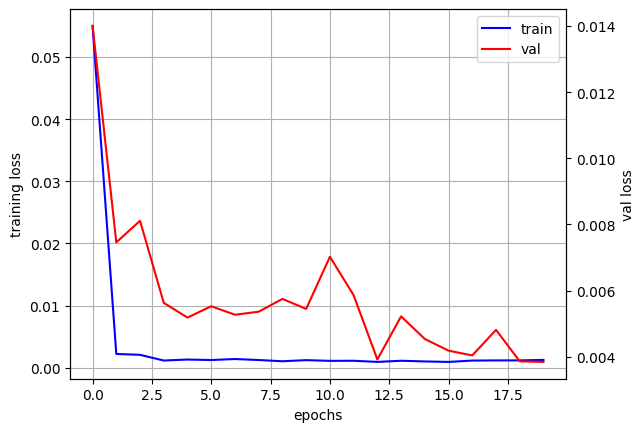

In [34]:
import matplotlib.pyplot as plt

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, lstm_model_history.history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, lstm_model_history.history['val_loss'],'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel(r"training loss")
ax2.set_ylabel(r"val loss")
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/best_lstm_model.jpg')
plt.show()

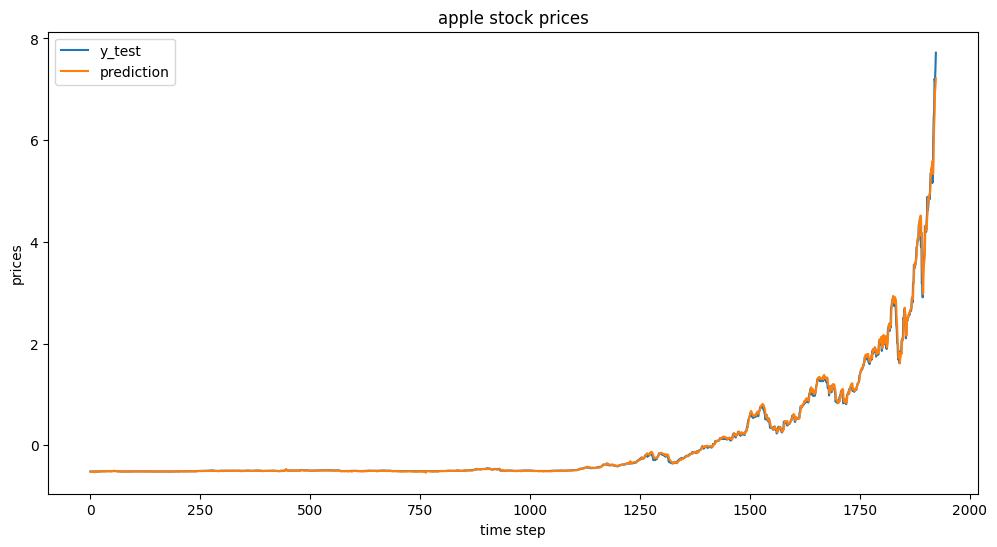

In [35]:
import matplotlib.pyplot as plt

# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(best_lstm_model_predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.xlabel('time step')
plt.ylabel('prices')
plt.show()

The enhanced LSTM model builds on the simple architecture by incorporating additional LSTM layers and dropout layers for regularization. It includes two LSTM layers with 100 units each and dropout layers between them. Similar to the simple model, the enhanced LSTM is trained using the Adam optimizer for 20 epochs.

In [36]:
# @title enhanced_LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Set up a checkpoint to save the best model based on the validation loss
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/enhanced_lstm_model.h5', monitor='val_loss',mode='auto' ,save_best_only='True', save_weights_only=False)
callback_lists=[checkpoint]

# Build a more complex LSTM model with multiple LSTM layers and dropout for regularization
enhanced_lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(1)
])
enhanced_lstm_model.compile(optimizer='adam', loss='mse')
enhanced_lstm_model.summary()


# Train the model and measure the training duration
t1 = time.time()
enhanced_lstm_model_history = enhanced_lstm_model.fit(X_train, y_train, epochs=20, verbose=1, batch_size=32, validation_data=(X_test, y_test), callbacks=callback_lists)
t2 = time.time() - t1
print("训练时长：{} h".format(t2/60/60))

# Save the training history for later analysis
with open('/content/drive/MyDrive/97/best_model/enhanced_lstm_model_history.txt', 'wb') as file:
    pickle.dump(enhanced_lstm_model_history.history, file)

# Use the trained model to make predictions on the test data
enhanced_lstm_predictions = enhanced_lstm_model.predict(X_test)

# Calculate and print various error metrics to evaluate the model's performance
enhanced_lstm_mse = mean_squared_error(y_test, enhanced_lstm_predictions)
enhanced_lstm_rmse = np.sqrt(enhanced_lstm_mse)
enhanced_lstm_mae = mean_absolute_error(y_test, enhanced_lstm_predictions)
enhanced_lstm_r2 = r2_score(y_test, enhanced_lstm_predictions)

print("Enhanced LSTM MSE:", enhanced_lstm_mse)
print("Enhanced LSTM RMSE:", enhanced_lstm_rmse)
print("Enhanced LSTM MAE:", enhanced_lstm_mae)
print("Enhanced LSTM R² score:", enhanced_lstm_r2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 100)           45200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 135801 (530.47 KB)
Trainable params: 135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 24s 98ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 3/20
248/248 [==============================] - 24s 96ms/step - loss: 0.0125 - val_loss: 0.0159
Epoch 4/20
248/248 [==============================] - 23s 92ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 5/20
248/248 [==============================] - 24s 98ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 6/20
248/248 [==============================] - 24s 97ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/20
248/248 [==============================] - 23s 93ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 8/20
248/248 [==============================] - 23s 93ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 9/20
248/248 [==============================] - 24s 96ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 10/20
248/248 [==============================] - 25s 102ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 11/20
248/248 [==============================] - 23s 92ms/step - loss: 0.0055 - val_l

In [37]:
# Load the best version of the enhanced LSTM model from storage
best_enhanced_lstm_model = load_model("/content/drive/MyDrive/97/best_model/enhanced_lstm_model.h5")

# Use the loaded model to make predictions on the test dataset
best_enhanced_lstm_model_predictions = best_enhanced_lstm_model.predict(X_test)

# Calculate error metrics to assess the model's performance
best_enhanced_lstm_model_mse = mean_squared_error(y_test, best_enhanced_lstm_model_predictions)
best_enhanced_lstm_model_rmse = np.sqrt(best_enhanced_lstm_model_mse)
best_enhanced_lstm_model_mae = mean_absolute_error(y_test, best_enhanced_lstm_model_predictions)
best_enhanced_lstm_model_r2 = r2_score(y_test, best_enhanced_lstm_model_predictions)

print("best_enhanced_lstm_model MSE:", best_enhanced_lstm_model_mse)
print("best_enhanced_lstm_model RMSE:", best_enhanced_lstm_model_rmse)
print("best_enhanced_lstm_model MAE:", best_enhanced_lstm_model_mae)
print("best_enhanced_lstm_model R² score:", best_enhanced_lstm_model_r2)

61/61 [==============================] - 2s 27ms/step
best_enhanced_lstm_model MSE: 0.004448793127890115
best_enhanced_lstm_model RMSE: 0.06669927381831166
best_enhanced_lstm_model MAE: 0.02645370221917771
best_enhanced_lstm_model R² score: 0.9961314874064217


Performance Metrics:

MSE: 0.0044 (Training) / 0.0044 (Test)

RMSE: 0.0667 (Training) / 0.0667 (Test)

MAE: 0.0265 (Training) / 0.0265 (Test)

R² Score: 0.9961 (Training) / 0.9961 (Test)

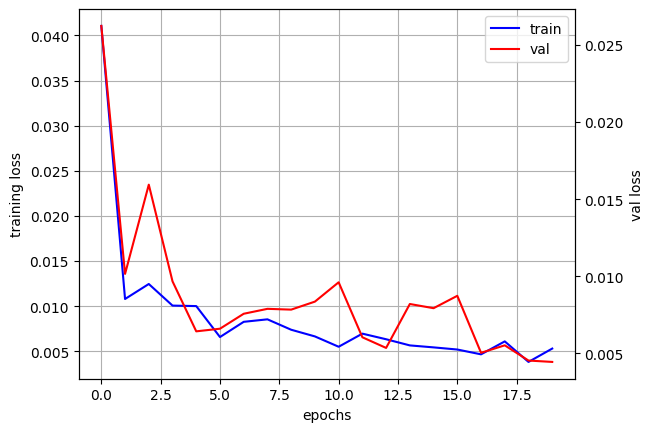

In [38]:
import matplotlib.pyplot as plt

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, enhanced_lstm_model_history.history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, enhanced_lstm_model_history.history['val_loss'],'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel(r"training loss")
ax2.set_ylabel(r"val loss")
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/enhanced_lstm_model.jpg')
plt.show()

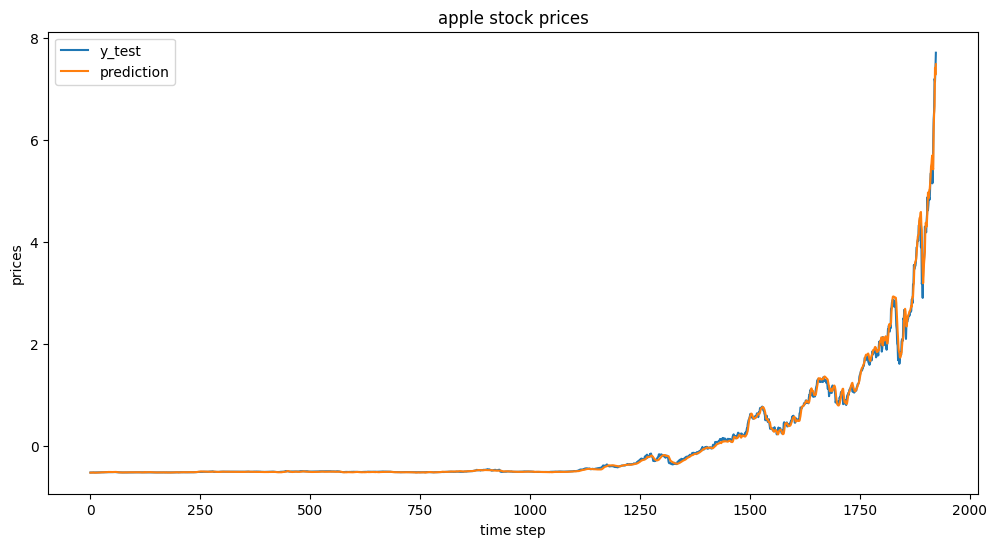

In [39]:
import matplotlib.pyplot as plt

# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(best_enhanced_lstm_model_predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.xlabel('time step')
plt.ylabel('prices')
plt.show()

Both models demonstrate high efficacy in predicting stock prices. The simple LSTM, however, offers a faster, highly accurate option for less complex datasets.

##Fine-tune the model

The GRU models have the best overall performance, with the lowest MSE and RMSE, and the highest R² score. It indicates very high accuracy and predictive power with small errors in predicting stock prices. GRU model will be fine-tuned.

In [40]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.7 MB/s eta 0:00:00


Tuning of GRU models defines custom model building functions to allow Keras Tuner to try different GRU layer configurations, dropout rates, and dense units. Optimization focuses on changing the number of units in the GRU layer, the dropout rate of the regularization, and the learning rate of the optimizer. Meanwhile, TimeSeriesSplit was used for manual cross-validation. After determining the optimal hyperparameters, the model is retrained and evaluated on multiple splits of the training data and finally on the held-out test set.

In [41]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras_tuner import RandomSearch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
from keras.callbacks import ModelCheckpoint

# Set up a checkpoint to save the best-performing model based on validation loss.
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/fine_tune_model.h5', monitor='val_loss',mode='auto' ,save_best_only='True', save_weights_only=False)
callback_lists=[checkpoint]

# Define a model building function for Keras Tuner to optimize GRU model architecture.
def build_model(hp):
    model = Sequential([
        GRU(units=hp.Int('units_gru_1', min_value=50, max_value=150, step=50),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)),
        GRU(units=hp.Int('units_gru_2', min_value=50, max_value=150, step=50)),
        Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mse')
    return model

# Configure Keras Tuner for random search of hyperparameters in the model building function.
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=3,
    directory='my_dir',
    project_name='enhanced_gru_tuning'
)

# Perform the hyperparameter search with a specified number of epochs, validation data, and verbosity level.
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1, callbacks=callback_lists)

Trial 3 Complete [00h 10m 23s]
val_loss: 0.0077073305534819765

Best val_loss So Far: 0.007431437261402607
Total elapsed time: 00h 34m 18s


In [42]:
# Retrieve the best hyperparameters from the tuning session
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Setup model checkpointing to save the best model based on validation loss.
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/97/best_model/fine_tune_model_last.h5', monitor='val_loss',mode='auto' ,save_best_only='True', save_weights_only=False)
callback_lists=[checkpoint]

# Setup for manual cross-validation specifically suitable for time series data.
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Rebuild the model using the best hyperparameters found
    model = build_model(best_hps)
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=callback_lists)

    predictions = model.predict(X_test_cv)
    mse_scores.append(mean_squared_error(y_test_cv, predictions))

# Evaluate the model on the full test dataset
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=callback_lists)
predictions = model.predict(X_test)

# Calculate error metrics for overall model evaluation
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Cross-validated MSE:", np.mean(mse_scores))
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R² score:", r2)

Epoch 1/20
42/42 [==============================] - 10s 142ms/step - loss: 0.0546 - val_loss: 0.5732
Epoch 2/20
42/42 [==============================] - 4s 88ms/step - loss: 0.0043 - val_loss: 0.5436
Epoch 3/20
42/42 [==============================] - 4s 88ms/step - loss: 0.0036 - val_loss: 0.5137
Epoch 4/20
42/42 [==============================] - 5s 113ms/step - loss: 0.0031 - val_loss: 0.4999
Epoch 5/20
42/42 [==============================] - 4s 95ms/step - loss: 0.0026 - val_loss: 0.4819
Epoch 6/20
42/42 [==============================] - 4s 89ms/step - loss: 0.0020 - val_loss: 0.4616
Epoch 7/20
42/42 [==============================] - 4s 104ms/step - loss: 0.0020 - val_loss: 0.4570
Epoch 8/20
42/42 [==============================] - 6s 144ms/step - loss: 0.0017 - val_loss: 0.4420
Epoch 9/20
42/42 [==============================] - 4s 88ms/step - loss: 0.0015 - val_loss: 0.4293
Epoch 10/20
42/42 [==============================] - 4s 91ms/step - loss: 0.0013 - val_loss: 0.4219
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 22s 89ms/step - loss: 0.0079 - val_loss: 0.3428
Epoch 2/20
207/207 [==============================] - 19s 90ms/step - loss: 0.0025 - val_loss: 0.3034
Epoch 3/20
207/207 [==============================] - 21s 101ms/step - loss: 0.0016 - val_loss: 0.2803
Epoch 4/20
207/207 [==============================] - 24s 114ms/step - loss: 0.0013 - val_loss: 0.2990
Epoch 5/20
207/207 [==============================] - 17s 83ms/step - loss: 0.0011 - val_loss: 0.3019
Epoch 6/20
207/207 [==============================] - 20s 98ms/step - loss: 9.9548e-04 - val_loss: 0.2580
Epoch 7/20
207/207 [==============================] - 16s 75ms/step - loss: 8.6132e-04 - val_loss: 0.2759
Epoch 8/20
207/207 [==============================] - 20s 97ms/step - loss: 8.3024e-04 - val_loss: 0.2734
Epoch 9/20
207/207 [==============================] - 16s 77ms/step - loss: 7.2893e-04 - val_loss: 0.2767
Epoch 10/20
207/207 [==============================] - 18s 85ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 28s 92ms/step - loss: 0.0612 - val_loss: 0.0159
Epoch 2/20
248/248 [==============================] - 21s 83ms/step - loss: 0.0142 - val_loss: 0.0108
Epoch 3/20
248/248 [==============================] - 22s 88ms/step - loss: 0.0115 - val_loss: 0.0162
Epoch 4/20
248/248 [==============================] - 20s 82ms/step - loss: 0.0086 - val_loss: 0.0138
Epoch 5/20
248/248 [==============================] - 23s 95ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 6/20
248/248 [==============================] - 28s 114ms/step - loss: 0.0073 - val_loss: 0.0106
Epoch 7/20
248/248 [==============================] - 20s 82ms/step - loss: 0.0066 - val_loss: 0.0091
Epoch 8/20
248/248 [==============================] - 29s 119ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 9/20
248/248 [==============================] - 22s 87ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 10/20
248/248 [==============================] - 21s 85ms/step - loss: 0.0058 - val_l

Cross-validated MSE: 0.2115

Test MSE: 0.0067

Test RMSE: 0.0820

Test MAE: 0.0341

Test R² Score: 0.9942

The increase in error metrics for fine-tuned GRU models may be due to over-optimization of the model, with too much focus on minimizing validation loss during the tuning process. The range and granularity of the hyperparameters searched may also be suboptimal. The random nature of searching the tuner results in the possibility of missing the best configuration. At the same time, if the model becomes too complex, it may learn the noise in the training data as part of the signal, which will reduce its performance on the test data. Although dropout is used as a regularization technique, its configuration during tuning may not be optimal, leading to overfitting.

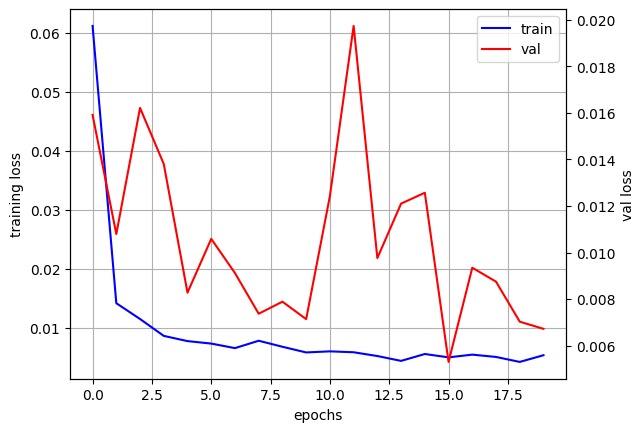

In [43]:
import matplotlib.pyplot as plt

# Create a plot to visualize training and validation loss
fig = plt.figure()
ax = fig.add_subplot(111)
x_data = range(20)
ax.plot(x_data, history.history['loss'], 'b', label='train')
ax2 = ax.twinx()
ax2.plot(x_data, history.history['val_loss'],'r', label='val')
ax.grid()
ax.set_xlabel("epochs")
ax.set_ylabel(r"training loss")
ax2.set_ylabel(r"val loss")
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=0)
plt.savefig('/content/drive/MyDrive/97/model.jpg')
plt.show()

The validation loss (red line) fluctuates greatly, although the overall trend is convergence. Especially in the middle period, the verification loss suddenly increased. This may be caused by overfitting. Since the dataset used in this study is relatively small, the model may be too complex to generalize to the validation data, and better regularization techniques are needed. Ideally, both training and validation losses should decrease steadily and converge, the lines should be smooth and converge, and there should not be much difference between training and validation losses.

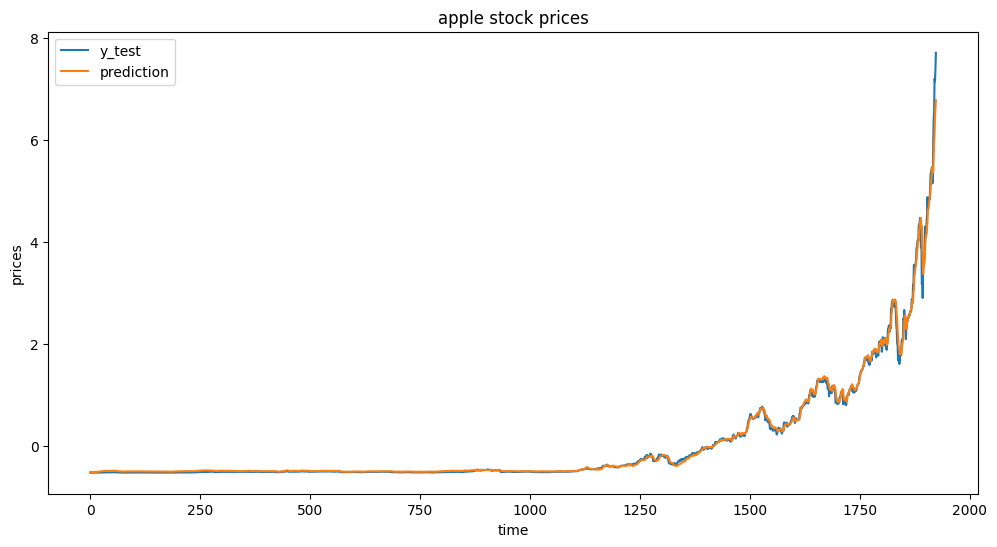

In [44]:
import matplotlib.pyplot as plt

# Create a plot to compare actual values against predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.title('apple stock prices')
plt.xlabel('time')
plt.ylabel('prices')
plt.show()

#Conclusion

This project implements and compares convolutional neural network (CNN), long short-term memory network (LSTM), and gated recurrent unit (GRU) models to deeply explore different neural network architectures for predicting stock prices. Performance metrics such as MSE, RMSE, MAE and R² score are carefully documented and show that the GRU model provides the best results. This demonstrates its superior ability to handle complex stock market data. However, fine-tuning results in an increase in the error metric, which may be attributed to a variety of factors, including the complexity of the model, the stochastic nature of the stock market, or possibly the limited size of the data set.